In [504]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import json
import datetime as dt
import re 
import yfinance as yf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
import requests
from get_all_tickers import get_tickers as gt
import bs4 as bs  # beautiful soups for web-scraping
import os
import pandas_datareader.data as pdr
import seaborn as sns

In [505]:
# user-defined functions
def clean_date_index(df):
    '''cleans date index of a dataframe such that the new format becomes year_period'''
    df.index = [str(x.year) + "_" + str(x.quarter) for x in df.index]
    return df

def calc_rets(df=None, nRows=None, nCols=None, index=None):
    '''calculates period returns given period price time series data within a dataframe'''
    rets = pd.DataFrame(np.zeros((nRows, nCols)), index = df.index, columns = index)
    for i in range(nCols):
        rets.iloc[:,i] = df.iloc[:,i] / df.iloc[:,i].shift(1) - 1
    rets = rets.shift(-1)  # shift n+1 period return into the n period row
    return rets

def qtr_hist_mkt_cap(ticker, start_qtr, end_qtr):
    '''outputs a dataframe with historical market cap data over quarterly periods from 2007-2020 given a ticker'''
    
    url_1 = "https://financialmodelingprep.com/api/v3/historical-market-capitalization/"
    url_2 = f"{ticker}?period=month&apikey=f0060c7a7b275396c21cb98f4985f3ae"
    mkt_cap = requests.get(url_1 + url_2)
    mkt_cap = mkt_cap.json()
    mkt_cap = pd.DataFrame(mkt_cap).set_index('date').drop(columns = ['symbol'], axis = 1)
    mkt_cap.index = pd.to_datetime(mkt_cap.index)
    mkt_cap = mkt_cap.resample('1M').mean()
    mkt_cap = mkt_cap.iloc[::3, :]  # quarterly data
    mkt_cap = clean_date_index(mkt_cap)
    mkt_cap = mkt_cap.loc[start_qtr:end_qtr,]  # slice data into sample timeframe
    mkt_cap.columns = pd.MultiIndex.from_tuples([(ticker, 'mkt_cap')])
    mkt_cap.index.names = ['qtr']
    return mkt_cap

def daily_hist_mkt_cap(ticker):
    '''outputs a dataframe with daily historical market cap data over entire history of the stock given a ticker'''
    
    url_1 = "https://financialmodelingprep.com/api/v3/historical-market-capitalization/"
    url_2 = f"{ticker}?apikey=f0060c7a7b275396c21cb98f4985f3ae"
    mkt_cap = requests.get(url_1 + url_2)
    mkt_cap = mkt_cap.json()
    mkt_cap = pd.DataFrame(mkt_cap).set_index('date').drop(columns = ['symbol'], axis = 1)
    mkt_cap.columns = pd.MultiIndex.from_tuples([(ticker, 'mkt_cap')])
    mkt_cap.index.names = ['date']
    return mkt_cap
    
def Piotroski_F_score(ticker, df):
    '''computes Piotroski F-score for a given ticker and dataframe of Bloomberg finanical data;
    outputs Series object of F-scores; ouputs DataFrame containing Piotroski F-score and financial ratio 
    components as columns for a given ticker'''
    
    # factor components
    ROA = df[ticker]["RETURN_ON_ASSET"]  # return on assets
    CFO = df[ticker]["CF_CASH_FROM_OPER"]  # cashflow from operations
    dROA = ROA.diff(4)  # y/y change in ROA 
    dTURN = df[ticker]['ASSET_TURNOVER'].diff(4)  # y/y change in asset turnover ratio
    dLEVER = df[ticker]['TOT_DEBT_TO_TOT_ASSET'].diff(4)  # y/y change leveraged assets
    # accrual
    NET_INCOME = df[ticker]["NET_INCOME"]
#     dNET_INCOME = NET_INCOME.diff(4)  # y/y change in net income
    TOT_CURR_ASSET = df[ticker]["BS_CUR_ASSET_REPORT"]
    TOT_CURR_LIABILITIES = df[ticker]['BS_CUR_LIAB']
    ACCRUAL = (NET_INCOME - CFO)/TOT_CURR_ASSET.shift(4)
    # y/y change in liquidity
    dLIQUID = TOT_CURR_ASSET/TOT_CURR_LIABILITIES - TOT_CURR_ASSET.shift(4)/TOT_CURR_LIABILITIES.shift(4)  
    dMARGIN = df[ticker]['GROSS_MARGIN'].diff(4)  # y/y change in gross margin ratio

    # factors
    f_index = ROA.index
    F_ROA = pd.Series(np.where(ROA > 0, 1, 0))  # F_ROA
    F_ROA.index = f_index
    F_dROA = pd.Series(np.where(dROA > 0, 1, 0))  # F_dROA
    F_dROA.index = f_index
    F_CFO = pd.Series(np.where(ROA > 0, 1, 0))  # F_CFO
    F_CFO.index = f_index
    F_ACCRUAL = pd.Series(np.where(CFO > ROA, 1, 0))  # F_ACCRUAL
    F_ACCRUAL.index = f_index
    F_dLEVER = pd.Series(np.where(dLEVER < dLEVER.shift(1), 1, 0))  # F_dLEVER
    F_dLEVER.index = f_index
    F_dLIQUID = pd.Series(np.where(dLIQUID > 0, 1, 0))  # F_dLIQUID
    F_dLIQUID.index = f_index
    F_dMARGIN = pd.Series(np.where(dMARGIN > 0, 1, 0))  # F_dMARGIN
    F_dMARGIN.index = f_index
    F_dTURN = pd.Series(np.where(dTURN > 0, 1, 0))  # F_dTURN
    F_dTURN.index = f_index

    # F-score
    F_score = F_ROA + F_dROA + F_CFO + F_ACCRUAL + F_dLEVER + F_dLIQUID + F_dMARGIN + F_dTURN 
    F_score = F_score[4:]  # remove the first year
    
    # construct DataFrame
    f_score_data = pd.DataFrame(F_score, index = F_score.index, columns = [ticker])
    f_score_data.columns = pd.MultiIndex.from_tuples([(ticker, 'f_score')])
    f_score_data.index.names = ['qtr']
    
    # component DataFrame
    ratios = [ROA, CFO, dROA, dTURN, dLEVER, ACCRUAL, dLIQUID, dMARGIN]
    ratio_names = ['ROA', 'CFO', 'dROA', 'dTURN', 'dLEVER', 'ACCRUAL', 'dLIQUID', 'dMARGIN']
    
    f_ratio_data = pd.concat(ratios, axis=1)
    f_ratio_data.columns = pd.MultiIndex.from_tuples([(ticker, name) for name in ratio_names])
    f_ratio_data.index.names = ['qtr']
    
    # merge F-score to component data
    merged_df = pd.merge(f_ratio_data, f_score_data, on='qtr', how='inner')
    
    return merged_df

def financial_ratios(ticker, df):
    ''' computes financial ratios given a ticker and financial statement data'''
    
    # factor components
    ROA = df[ticker]["RETURN_ON_ASSET"]  # return on assets
    CFO = df[ticker]["CF_CASH_FROM_OPER"]  # cashflow from operations
    dROA = ROA.diff(4)  # y/y change in ROA 
    dTURN = df[ticker]['ASSET_TURNOVER'].diff(4)  # y/y change in asset turnover ratio
    dLEVER = df[ticker]['TOT_DEBT_TO_TOT_ASSET'].diff(4)  # y/y change leveraged assets
    # accrual
    NET_INCOME = df[ticker]["NET_INCOME"]
    dNET_INCOME = NET_INCOME.diff(4)  # y/y change in net income
    TOT_CURR_ASSET = df[ticker]["BS_CUR_ASSET_REPORT"]
    TOT_CURR_LIABILITIES = df[ticker]['BS_CUR_LIAB']
    ACCRUAL = (NET_INCOME - CFO)/TOT_CURR_ASSET.shift(4)
    # y/y change in liquidity
    dLIQUID = TOT_CURR_ASSET/TOT_CURR_LIABILITIES - TOT_CURR_ASSET.shift(4)/TOT_CURR_LIABILITIES.shift(4)  
    dMARGIN = df[ticker]['GROSS_MARGIN'].diff(4)  # y/y change in gross margin ratio
    
    return (ROA, CFO, dROA, dTURN, dLEVER, NET_INCOME, dNET_INCOME, TOT_CURR_ASSET, TOT_CURR_LIABILITIES, ACCRUAL,
           dLIQUID, dMARGIN)

The below tickers are the current tickers in the S&P 500...
- Ideally I would like to include all tickers that have been in the S&P 500 over the past 5 years or so, including those that have delisted.
    - Dieyna was able to get a list of historical S&P500 ticker data. However it is proving difficult to do anything useful with the data because there are no easy (or cheap) ways of getting historical financial statement data given a list of tickers (ticker is not a great identifier for a stock).
- How to deal with stock ticker name changes?

In [506]:
# fundamental data of companies in S&P 500 sourced from Bloomberg Terminal
SP_500_fund_df = pd.read_excel('SP500_fundamental_data.xlsx', index_col = 0, header=[0,1])
SP_500_fund_df = SP_500_fund_df.rename(str.strip, axis='columns')  # strip trailing whitespace from column names
SP_500_fund_df = clean_date_index(SP_500_fund_df)
SP_500_fund_df = SP_500_fund_df.stack(0).dropna().unstack()  # drop all rows containing nulls 
SP_500_fund_df.columns = SP_500_fund_df.columns.swaplevel(0, 1)
SP_500_fund_df.sort_index(axis=1, level=0, inplace=True)
SP_500_fund_df.head()

A                                                    \
Dates  ASSET_TURNOVER BS_CUR_ASSET_REPORT BS_CUR_LIAB CF_CASH_FROM_OPER   
2006_1         0.6115              4626.0      1637.0            -128.0   
2006_2         0.6005              4576.0      1784.0             326.0   
2006_3         0.6098              4219.0      1679.0              35.0   
2006_4         0.7044              3958.0      1538.0             401.0   
2007_1         0.6684              3749.0      1372.0              93.0   

                                                                      \
Dates  GROSS_MARGIN NET_INCOME RETURN_ON_ASSET TOT_DEBT_TO_TOT_ASSET   
2006_1      51.5853     2816.0         40.0633               18.6893   
2006_2      51.7353      115.0         39.9347               18.6174   
2006_3      55.3672      227.0         42.2121               19.4074   
2006_4      54.8946      149.0         46.8414               20.3555   
2007_1      53.9844      150.0          8.4237               20.8536   

                  AAP                      ...            ZBRA  \
Dates  ASSET_TURNOVER BS_CUR_ASSET_REPORT  ... RETURN_ON_ASSET   
2006_1            NaN                 NaN  ...             NaN   
2006_2            NaN                 NaN  ...         11.4120   
2006_3            NaN                 NaN  ...          8.1637   
2006_4            NaN                 NaN  ...          7.5412   
2007_1            NaN                 NaN  ...          7.3274   

                                        ZTS                                  \
Dates  TOT_DEBT_TO_TOT_ASSET ASSET_TURNOVER BS_CUR_ASSET_REPORT BS_CUR_LIAB   
2006_1                   NaN            NaN                 NaN         NaN   
2006_2                   0.0            NaN                 NaN         NaN   
2006_3                   0.0            NaN                 NaN         NaN   
2006_4                   0.0            NaN                 NaN         NaN   
2007_1                   0.0            NaN                 NaN         NaN   

                                                                  \
Dates  CF_CASH_FROM_OPER GROSS_MARGIN NET_INCOME RETURN_ON_ASSET   
2006_1               NaN          NaN        NaN             NaN   
2006_2               NaN          NaN        NaN             NaN   
2006_3               NaN          NaN        NaN             NaN   
2006_4               NaN          NaN        NaN             NaN   
2007_1               NaN          NaN        NaN             NaN   

                              
Dates  TOT_DEBT_TO_TOT_ASSET  
2006_1                   NaN  
2006_2                   NaN  
2006_3                   NaN  
2006_4                   NaN  
2007_1                   NaN  

[5 rows x 3200 columns]

In [507]:
# ticker list
tickers = list(set(SP_500_fund_df.columns.get_level_values(0)))
tickers.sort()

# F-scores and components given S&P 500 ticker and construct dataframe with all tickers (0 = lowest, 8 = highest)
f_score_list = []

for ticker in tickers:
    f_score = Piotroski_F_score(ticker, SP_500_fund_df)
    f_score_list.append(f_score)
    
f_score_df = pd.concat(f_score_list, axis=1)

# historical market cap data using FMP API 
start_qtr = '2007_1'
end_qtr = '2020_4'

mkt_cap_df = qtr_hist_mkt_cap(tickers[0], start_qtr, end_qtr)

for ticker in tickers[1:]:
    print(ticker)
    mkt_cap = qtr_hist_mkt_cap(ticker, start_qtr, end_qtr)
    mkt_cap_df = pd.merge(mkt_cap_df, mkt_cap, on='qtr', how='left')
    
mkt_cap_df = mkt_cap_df/1000000  # scale down by 1 million

AAP
AAPL
ABBV
ABC
ABMD
ABT
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AJG
AKAM
ALB
ALGN
ALLE
AMAT
AMCR
AMD
AME
AMGN
AMZN
ANET
ANSS
ANTM
AOS
APA
APD
APH
APTV
ATO
ATVI
AVGO
AVY
AZO
BA
BAX
BBWI
BBY
BDX
BF-B
BIIB
BIO
BKNG
BKR
BLL
BMY
BR
BRK-B
BSX
BWA
CAG
CAH
CARR
CAT
CBRE
CCL
CDAY
CDNS
CDW
CE
CERN
CF
CHD
CHRW
CHTR
CI
CL
CLX
CMCSA
CMG
CMI
CMS
CNC
CNP
COO
COP
COST
CPB
CPRT
CRL
CRM
CSCO
CTAS
CTLT
CTRA
CTSH
CTVA
CTXS
CVS
CVX
CZR
D
DD
DE
DG
DGX
DHI
DHR
DIS
DISCA
DISCK
DISH
DLTR
DOV
DOW
DPZ
DRI
DTE
DUK
DVA
DVN
DXC
DXCM
EA
EBAY
ECL
ED
EFX
EIX
EL
EMN
EMR
ENPH
EOG
EQIX
ES
ETN
ETR
ETSY
EVRG
EW
EXC
EXPD
EXPE
F
FANG
FAST
FB
FBHS
FCX
FDX
FE
FFIV
FIS
FISV
FMC
FTNT
FTV
GD
GE
GILD
GIS
GLW
GM
GNRC
GOOG
GOOGL
GPC
GPN
GPS
GRMN
GWW
HAL
HAS
HBI
HD
HES
HII
HLT
HOLX
HON
HPE
HPQ
HRL
HSIC
HSY
HUM
HWM
IBM
IDXX
IEX
IFF
ILMN
INCY
INFO
INTC
INTU
IP
IPGP
IQV
IR
IRM
ISRG
IT
ITW
J
JBHT
JCI
JKHY
JNJ
JNPR
K
KEYS
KHC
KLAC
KMB
KMI
KMX
KO
KR
LDOS
LEG
LEN
LH
LHX
LIN
LKQ
LLY
LMT
LNT
LOW
LRCX
LUMN
LVS
LW
LYB
LYV
MAR
MAS
MCD
MCHP
MCK


In [423]:
# S&P quarterly returns over sample period
SPX_mo_prices = pd.read_excel('SP500_mo_price_data_07-20.xlsx', index_col=0)
SPX_qtr_prices = SPX_mo_prices.iloc[::3]
SPX_qtr_prices = clean_date_index(SPX_qtr_prices)  # clean date index
N = SPX_qtr_prices.shape[0]
M = SPX_qtr_prices.shape[1]
SPX_qtr_rets = calc_rets(SPX_qtr_prices, N, M, ["SPX_qtr_rets"])

# price per earnings ratio 
SP500_PE_ratio = pd.read_excel('SP500_PE_ratio_monthly_07-20.xlsx', index_col=0, header = [0,1])
SP500_PE_ratio = SP500_PE_ratio.rename(str.strip, axis='columns')  # strip trailing whitespace from column names
SP500_PE_ratio = SP500_PE_ratio.iloc[::3, :]  # quarterly data
SP500_PE_ratio = clean_date_index(SP500_PE_ratio)  # clean date index

# create multi-level quarterly returns df
N = SP500_PE_ratio.shape[0]
tickers = list(SP500_PE_ratio.columns.get_level_values(0))  # level 1
tickers = list(set(tickers))  # keep only unique ticker names
ret_col = ["qtr_ret"]*len(tickers)  # level 2
tuples = list(zip(tickers, ret_col))
index = pd.MultiIndex.from_tuples(tuples, names=[None, "Dates"])

qtr_rets = calc_rets(SP500_PE_ratio, N, len(tickers), index)

# merge PE ratio dataset to future qtr return dataset
PE_ratio_qtr_rets_df = pd.merge(SP500_PE_ratio, qtr_rets, left_index=True, right_index=True)
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df.sort_index(axis=1)
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df.drop('PX_LAST', axis=1, level=1)  # drop "Last Price" col

# create stacked dataframe and clean
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df.stack(0)
PE_ratio_qtr_rets_df
PE_ratio_qtr_rets_df['EP_RATIO'] = np.reciprocal(PE_ratio_qtr_rets_df['PE_RATIO'])  # create Earnings/Price Ratio col
PE_ratio_qtr_rets_df.drop(PE_ratio_qtr_rets_df.columns[0], axis=1, inplace=True)  # drop PE_RATIO col
PE_ratio_qtr_rets_df['EP_RATIO'].fillna(0, inplace=True)  # change NaN values to 0 in EP_RATIO col
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df[["EP_RATIO", "qtr_ret"]]
PE_ratio_qtr_rets_df = PE_ratio_qtr_rets_df.dropna()

# merge SPX market returns
PE_ratio_qtr_rets_df.index.names = ['qtr', 'ticker']
SPX_qtr_rets.index.names = ['qtr']
df = pd.merge(PE_ratio_qtr_rets_df.reset_index(), 
              SPX_qtr_rets.reset_index(),
              how='inner',
              on='qtr').set_index(['qtr', 'ticker'])

# merge mkt cap data to panel df
mkt_cap_stacked = mkt_cap_df.stack(0)
mkt_cap_stacked.index.names = ['qtr','ticker']
df = pd.merge(df.reset_index(), 
              mkt_cap_stacked.reset_index(),
              how='inner',
              on=['qtr','ticker']).set_index(['qtr', 'ticker'])

# merge F-score data to panel df 
f_score_stacked = f_score_df.stack(0)
f_score_stacked.index.names = ['qtr','ticker']
df = pd.merge(df.reset_index(), 
              f_score_stacked.reset_index(),
              how='inner',
              on=['qtr','ticker']).set_index(['qtr', 'ticker'])

# create column for the median market cap of all assets in each quarter
median_mkt_cap = df.groupby(by='qtr').median()[['mkt_cap']]
median_mkt_cap.columns = ['median_mkt_cap']
df = df.join(median_mkt_cap, how='left')

# create dummy market cap column (1 = mkt_cap >= median mkt_cap; 0 = mkt_cap < median mkt_cap)
df['size'] = 0
df.loc[df['mkt_cap'] >= df['median_mkt_cap'], 'size'] = 1

# create interaction terms between company size and EP Ratio, and company size and F-score, respectively
df['EP_ratio_size'] = df['EP_RATIO'] * df['size']
df['F_score_size'] = df['f_score'] * df['size']

# create beats_market column (underperforms = 0; outperforms/equals = 1)
df['beats_market'] = 0
df.loc[df['qtr_ret'] >= df['SPX_qtr_rets'], 'beats_market'] = 1
df = df.dropna()
df.to_csv("/Users/taigaschwarz/Dev/quant-trading-mf703/output/regression_data.csv")
df

EP_RATIO   qtr_ret  SPX_qtr_rets       mkt_cap   ACCRUAL  \
qtr    ticker                                                             
2007_1 A       0.057223 -0.044928      0.030683   9769.315789  0.012322   
       AAPL    0.032311  0.080176      0.030683  80341.150909  0.003544   
       ABC     0.048007 -0.060871      0.030683   9497.865000 -0.031878   
       ABMD    0.000000  0.039663      0.030683    383.278500  0.003424   
       ACN     0.040339 -0.159686      0.030683  32260.880000 -0.067251   
...                 ...       ...           ...           ...       ...   
2020_3 XRAY    0.018812 -0.041562     -0.000355   9702.885805 -0.085574   
       XYL     0.030870 -0.081938     -0.000355  12904.937100 -0.105170   
       ZBH     0.045735  0.294024     -0.000355  26487.226009 -0.031535   
       ZBRA    0.036412 -0.088137     -0.000355  15147.520991 -0.048741   
       ZTS     0.024033 -0.101159     -0.000355  75728.079764 -0.017973   

                   CFO      ROA  dLEVER   dLIQUID  dMARGIN     dROA   dTURN  \
qtr    ticker                                                                 
2007_1 A        93.000   8.4237  2.1643 -0.093394   2.3991 -31.6396  0.0569   
       AAPL    734.000  17.1734  0.0000  0.423805   5.2625   2.8365 -0.1145   
       ABC     422.936   3.7403  0.3777 -0.085019  -0.0116   0.9506  0.1768   
       ABMD     -6.508 -25.9696  0.0000  2.158758   8.0789  16.2201 -0.1539   
       ACN     710.178  14.3635 -0.3398  0.070474   7.8390   4.9857  0.1667   
...                ...      ...     ...       ...      ...      ...     ...   
2020_3 XRAY    208.000  -0.9269  7.3759  0.104852  -4.0393  -2.8223 -0.0736   
       XYL     275.000   2.8065  3.0030  1.037780  -1.4878  -4.0394 -0.0987   
       ZBH     381.300  -0.6285 -0.9321  1.107374  -0.9911  -1.7940 -0.1863   
       ZBRA    176.000   9.5248 -3.2221 -0.267219  -3.7939  -1.2350 -0.1023   
       ZTS     562.000  13.3056 -1.7061 -1.574317  -0.3312  -0.1406 -0.0426   

               f_score  median_mkt_cap  size  EP_ratio_size  F_score_size  \
qtr    ticker                                                               
2007_1 A             5     8826.188955     1       0.057223             5   
       AAPL          6     8826.188955     1       0.032311             6   
       ABC           5     8826.188955     1       0.048007             5   
       ABMD          4     8826.188955     0       0.000000             0   
       ACN           7     8826.188955     1       0.040339             7   
...                ...             ...   ...            ...           ...   
2020_3 XRAY          2    24648.446104     0       0.000000             0   
       XYL           5    24648.446104     0       0.000000             0   
       ZBH           2    24648.446104     1       0.045735             2   
       ZBRA          3    24648.446104     0       0.000000             0   
       ZTS           4    24648.446104     1       0.024033             4   

               beats_market  
qtr    ticker                
2007_1 A                  0  
       AAPL               1  
       ABC                0  
       ABMD               1  
       ACN                0  
...                     ...  
2020_3 XRAY               0  
       XYL                0  
       ZBH                1  
       ZBRA               0  
       ZTS                0  

[17073 rows x 18 columns]

# Data Visualization

<AxesSubplot:xlabel='f_score', ylabel='beats_market'>

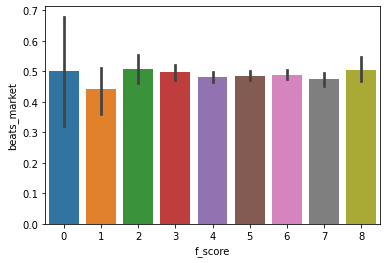

In [503]:
sns.barplot(x='f_score', y= 'beats_market', data=df)

In [492]:
# logistic regression model -- F-score included
x_cols = ['EP_RATIO', 'EP_ratio_size', 'F_score_size', 'f_score']
y_col = 'beats_market'

X = pd.DataFrame(df[x_cols])

# scale data to standardize
scaler = MinMaxScaler()
scaled_EP_ratio_train = scaler.fit_transform(X[['EP_RATIO']]) 
scaled_f_score_train = scaler.fit_transform(X[['f_score']])
scaled_EP_ratio_size_train = scaler.fit_transform(X[['EP_ratio_size']])
scaled_f_score_size_train = scaler.fit_transform(X[['F_score_size']])
X.loc[:,['EP_RATIO']] = scaled_EP_ratio_train 
X.loc[:, ['f_score']] = scaled_f_score_train
X.loc[:, ['EP_ratio_size']] = scaled_EP_ratio_size_train
X.loc[:, ['F_score_size']] = scaled_f_score_size_train

Y = df[y_col]

# split data into train and test 
X_train = X.loc['2007_1':'2015_2',:]
Y_train = Y.loc['2007_1':'2015_2',:]
X_test = X.loc['2015_3':'2016_4',:]
Y_test = Y.loc['2015_3':'2016_4',:]

# add an intercept column
X_train['intercept'] = 1
X_test['intercept'] = 1

print('training data shape: ', X_train.shape)
print('test data shape: ', X_test.shape)
print('proportion = ', X_test.shape[0] / X_train.shape[0])  # about an 80 - 20 split between training and test data

# train model
lrg_1 = sm.Logit(Y_train, X_train).fit()  # statsmodels logit 

lreg_1 = LogisticRegression(penalty='none').fit(X_train, Y_train)  # scikit-learn log regression -- no regularization

# above two packages should result in the same coefficients
print(lreg_1.coef_)
print(lrg_1.summary())

training data shape:  (9500, 5)
test data shape:  (2067, 5)
proportion =  0.21757894736842107
Optimization terminated successfully.
         Current function value: 0.693007
         Iterations 4
[[ 0.032932    0.63549645 -0.0838297  -0.05196555  0.01162524]]
                           Logit Regression Results                           
Dep. Variable:           beats_market   No. Observations:                 9500
Model:                          Logit   Df Residuals:                     9495
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:               0.0001504
Time:                        19:07:14   Log-Likelihood:                -6583.6
converged:                       True   LL-Null:                       -6584.6
Covariance Type:            nonrobust   LLR p-value:                    0.7393
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

/var/folders/nc/rw9wphy93wld5jj0hn7glwbm0000gn/T/ipykernel_2022/3574560069.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['intercept'] = 1
/var/folders/nc/rw9wphy93wld5jj0hn7glwbm0000gn/T/ipykernel_2022/3574560069.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['intercept'] = 1


/var/folders/nc/rw9wphy93wld5jj0hn7glwbm0000gn/T/ipykernel_2022/711488577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_test['pred_prob_beat'] = y_pred_train


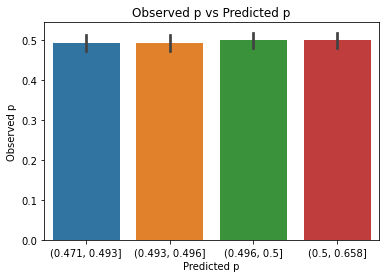

In [493]:
# model 1 performance on training set
X_train_test = X_train
y_pred_train = lrg_1.predict(X_train)
X_train_test['pred_prob_beat'] = y_pred_train
test = X_train_test.reset_index()
Y_train_test = Y_train.reset_index()
test['beats_mkt'] = Y_train_test['beats_market']
test = test.sort_values(by=['pred_prob_beat'], ascending=False)
test['quantile'] = pd.qcut(test['pred_prob_beat'], 4)

sns.barplot(x='quantile', y= 'beats_mkt', data=test)
plt.ylabel('Observed p')
plt.xlabel('Predicted p')
plt.title('Observed p vs Predicted p')
plt.savefig("/Users/taigaschwarz/Dev/quant-trading-mf703/output/observed_v_pred_p.png", format="png", 
            dpi=1200)
plt.show()

The logistic regression model is fitting the probability that a given stock in the S&P 500 will outperform the market in the next period given the current period's Earnings/Price ratio, Piotroski F-score, and interaction terms between E/P ratio and company size and F-score and company size, respectively. This idea is drawn from Joseph Piotroski's stock selection research publication 2002 in which he applies an investment strategy on high Book-to-Market companies with favorable F-scores. High BTM companies can be thought of as companies that have more instrinsic value than its market value. Since Book-to-Market ratio calculation can be a rather tedious process in financial accounting, we use E/P ratio as a proxy valuation factor. Furthermore, Piotroski also notes the possibility of size bias in that larger companies generally have more investor scrutiny and thus its share price reacts quicker to changes in company financials. Thus, we incorporate company size interaction terms for both E/P ratio and F-score. We then train and validate a logistic regression model using these predictors. <br>

Analyzing our model, we see that the predictors (including the intercept) are not significant, thus the predicted probability of outperformance should be 50% as we would expect from the logistic regression model:

$$p = \frac{1}{1+e^-({\beta_{0}+\beta_{1}*(EP ratio)+\beta_{2}*(f score)+\beta_{3}*(EP  ratio*size)+\beta_{4}*(f score*size))}} = \frac{1}{2},$$ where all $\beta_i = 0$. 

See below that the correlation matrix also indicates that there is very little correlation between the predictors and the next period's quarterly return.

<AxesSubplot:>

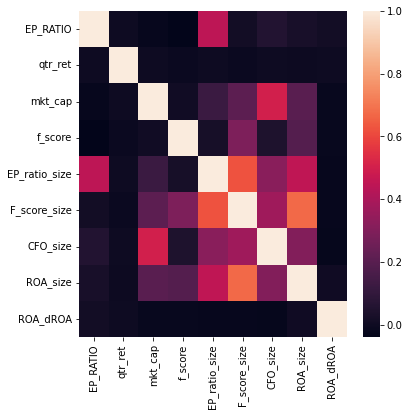

In [494]:
# correlation matrix -- F-score included
df_temp = df.reset_index()
df_temp = df_temp.drop(['SPX_qtr_rets', 'median_mkt_cap', 'beats_market',
                        'ACCRUAL', 'CFO', 'ROA', 'CFO', 'dLEVER', 'dLIQUID',
                        'dMARGIN', 'dROA', 'dTURN', 'size'], axis=1)
corr_matrix = df_temp.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix)

One possible issue is that the Piotroski F-score is an aggregation of binary factors, and thus it eliminates most of the potentially significant variation within each financial ratio that is a component of the F-score. For example, consider that Return on Assets increases y/y by some extreme value (e.g. 500%) for one company, and by a much smaller value (e.g. 5%) for another company. The binary nature of the dROA factor causes both of these increases to have the same impact on the company's F-score, as both would result in a dROA value of 1. This can be potentially problematic, so we replace the F-score with its component financial ratios, and conduct the same analysis as above.

<AxesSubplot:>

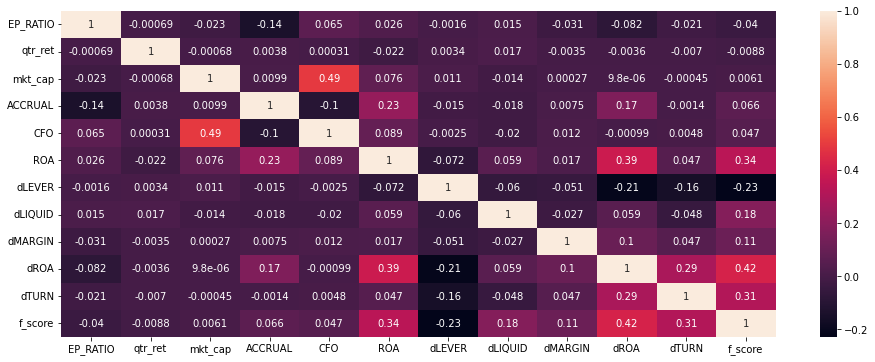

In [495]:
# correlation matrix -- F-score components included
df_temp = df.reset_index()
df_temp = df_temp.drop(['SPX_qtr_rets', 'median_mkt_cap', 'beats_market', 'EP_ratio_size', 'F_score_size',
                       'CFO_size', 'ROA_size', 'ROA_dROA','size'], axis=1)
corr_matrix = df_temp.corr()

plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True)

There looks to be possibly more of a relationship between these factors and quarterly return, although the correlations are still very low. We also see potentially significant correlation between market capitalization and ROA, and also with CFO. This signals interaction between company size and its Return on Assets ratio and its Cashflow from Operations. We also see potentially significant correlation between ROA and dROA.

In [496]:
# logistic regression model -- F-score components used 

# create interaction term between CFO and size, and ROA and size
df['CFO_size'] = df['CFO'] * df['size']
df['ROA_size'] = df['ROA'] * df['size']
df['ROA_dROA'] = df['ROA'] * df['dROA']

# define column names
x_cols = ['EP_RATIO', 'ACCRUAL', 'CFO', 'ROA', 'dLEVER', 'dLIQUID', 'dMARGIN', 'dROA', 'dTURN',
         'CFO_size', 'ROA_size', 'ROA_dROA']

X2 = pd.DataFrame(df[x_cols])
scaled_EP_ratio_train = scaler.fit_transform(X2[['EP_RATIO']])  # standardize data
scaled_ACCRUAL_train = scaler.fit_transform(X2[['ACCRUAL']])
scaled_CFO_train = scaler.fit_transform(X2[['CFO']])
scaled_ROA_train = scaler.fit_transform(X2[['ROA']])
scaled_dLEVER_train = scaler.fit_transform(X2[['dLEVER']])
scaled_dLIQUID_train = scaler.fit_transform(X2[['dLIQUID']])
scaled_dMARGIN_train = scaler.fit_transform(X2[['dMARGIN']])
scaled_dROA_train = scaler.fit_transform(X2[['dROA']])
scaled_dTURN_train = scaler.fit_transform(X2[['dTURN']])
scaled_CFO_size_train = scaler.fit_transform(X2[['CFO_size']])
scaled_ROA_size_train = scaler.fit_transform(X2[['ROA_size']])
scaled_ROA_dROA_train = scaler.fit_transform(X2[['ROA_dROA']])
X2.loc[:,['EP_RATIO']] = scaled_EP_ratio_train 
X2.loc[:, ['ACCRUAL']] = scaled_ACCRUAL_train
X2.loc[:, ['CFO']] = scaled_CFO_train
X2.loc[:, ['ROA']] = scaled_ROA_train
X2.loc[:, ['dLEVER']] = scaled_dLEVER_train
X2.loc[:, ['dLIQUID']] = scaled_dLIQUID_train
X2.loc[:, ['dMARGIN']] = scaled_dMARGIN_train
X2.loc[:, ['dROA']] = scaled_dROA_train
X2.loc[:, ['dTURN']] = scaled_dTURN_train
X2.loc[:, ['CFO_size']] = scaled_CFO_size_train
X2.loc[:, ['ROA_size']] = scaled_ROA_size_train
X2.loc[:, ['ROA_dROA']] = scaled_ROA_dROA_train

# split data
X2_train = X2.loc['2007_1':'2015_2',:]
X2_test = X2.loc['2015_3':'2016_4',:]

# add intercepts
X2_train['intercept'] = 1
X2_test['intercept'] = 1

lrg_2 = sm.Logit(Y_train, X2_train).fit()  # statsmodels logit 

lreg_2 = LogisticRegression(penalty='none').fit(X2_train, Y_train)  # scikit-learn log regression -- no regularization

# above two packages should result in the same coefficients
print(lreg_2.coef_)
print(lrg_2.summary())

Optimization terminated successfully.
         Current function value: 0.692119
         Iterations 5
[[ 2.66234219e-03 -2.72227336e+00 -8.54346496e+00 -2.91297248e-01
  -9.01420917e-01 -1.20644026e-01 -1.37034128e+01 -3.37080738e-01
  -3.93103943e-02  8.88753523e+00 -1.32436189e-01  9.94323011e-01
   7.16099640e+00]]
                           Logit Regression Results                           
Dep. Variable:           beats_market   No. Observations:                 9500
Model:                          Logit   Df Residuals:                     9487
Method:                           MLE   Df Model:                           12
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                0.001433
Time:                        19:08:01   Log-Likelihood:                -6575.1
converged:                       True   LL-Null:                       -6584.6
Covariance Type:            nonrobust   LLR p-value:                   0.09175
                 coef    std err          z     

/var/folders/nc/rw9wphy93wld5jj0hn7glwbm0000gn/T/ipykernel_2022/183237615.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_train['intercept'] = 1
/var/folders/nc/rw9wphy93wld5jj0hn7glwbm0000gn/T/ipykernel_2022/183237615.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2_test['intercept'] = 1
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of

We see that CFO, CFO_size, ACCRUAL, and the intercept are statistically significant under a 95% confidence level. dMargin has a 0.08 p-value, so we will keep it in the model. We will drop the rest of the variables from the model for simplicity (although we may risk "P-hacking"). 

In [499]:
# simplified model
X3_train = X2_train['CFO', 'CFO_size', 'ACCRUAL', 'dMARGIN','intercept']
X3_test = X2_test[['CFO', 'CFO_size', 'ACCRUAL', 'dMARGIN', 'intercept']]

lrg_3 = sm.Logit(Y_train, X3_train).fit()  # statsmodels logit 
lreg_3 = LogisticRegression(penalty='none').fit(X3_train, Y_train)  # scikit-learn log regression -- no regularization

# above two packages should result in the same coefficients
print(lreg_3.coef_)
print(lrg_3.summary())

Optimization terminated successfully.
         Current function value: 0.692375
         Iterations 5
[[  0.03869193 -17.64032497  17.70128502  -3.77241049  -9.58302963
    5.50540392]]
                           Logit Regression Results                           
Dep. Variable:           beats_market   No. Observations:                 9500
Model:                          Logit   Df Residuals:                     9494
Method:                           MLE   Df Model:                            5
Date:                Thu, 09 Dec 2021   Pseudo R-squ.:                0.001063
Time:                        17:45:39   Log-Likelihood:                -6577.6
converged:                       True   LL-Null:                       -6584.6
Covariance Type:            nonrobust   LLR p-value:                   0.01566
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EP_RATIO       0.0390   

/var/folders/nc/rw9wphy93wld5jj0hn7glwbm0000gn/T/ipykernel_2022/18425470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3_train_test['pred_prob_beat'] = y_pred_train


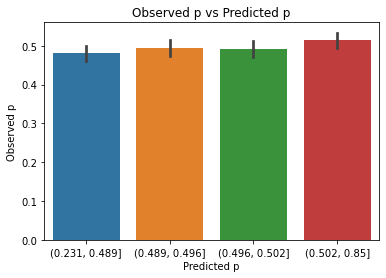

In [498]:
# model 2 performance on training set
X3_train_test = X3_train
y_pred_train = lrg_3.predict(X3_train)
X3_train_test['pred_prob_beat'] = y_pred_train
test2 = X3_train_test.reset_index()
Y_train_test = Y_train.reset_index()
test2['beats_mkt'] = Y_train_test['beats_market']
test2 = test2.sort_values(by=['pred_prob_beat'], ascending=False)
test2['quantile'] = pd.qcut(test2['pred_prob_beat'], 4)

sns.barplot(x='quantile', y= 'beats_mkt', data=test2)
plt.ylabel('Observed p')
plt.xlabel('Predicted p')
plt.title('Observed p vs Predicted p')
plt.savefig("/Users/taigaschwarz/Dev/quant-trading-mf703/output/observed_v_pred_p2.png", format="png", 
            dpi=1200)
plt.show()

0.4915336236090953


Text(0.5, 1.0, 'Accuracy Score: 0.4915336236090953')

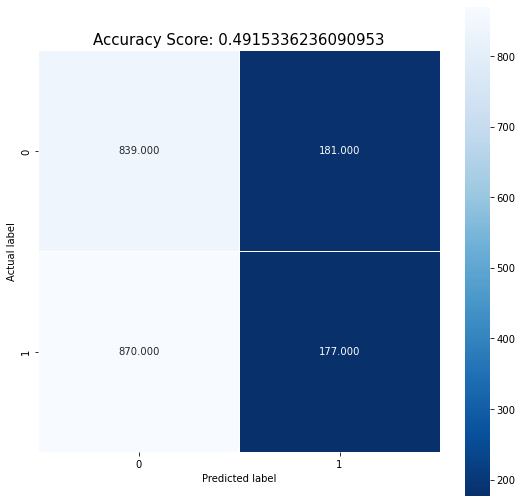

In [425]:
### model validation

# predictions
y_pred = lrg_3.predict(X3_test)
predictions = list(map(round, y_pred))

# accuracy
score = accuracy_score(Y_test, predictions)
print(score)
cm = confusion_matrix(Y_test, predictions)

# plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [381]:
# at what rate do we beat the market in our observed set?
print(np.mean(df.beats_market))

0.48614771862004336


In [369]:
# df_2010_1 = df.xs('2010_1')
# df_2010_1['qtr_ret']
df_groupby_ticker = df.groupby('ticker').mean()
df_groupby_ticker.describe()

,EP_RATIO,qtr_ret,SPX_qtr_rets,mkt_cap,ACCRUAL,CFO,ROA,dLEVER,dLIQUID,dMARGIN,...,dTURN,f_score,median_mkt_cap,size,EP_ratio_size,F_score_size,beats_market,CFO_size,ROA_size,ROA_dROA
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,...,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,0.052764,0.069530,0.020654,39499.414267,-0.069237,841.141415,7.000971,1.266571,-0.012146,-0.252448,...,-0.025285,5.160525,16054.834686,0.484920,0.026042,2.536675,0.485981,740.156495,3.983862,25.670461
std,0.035451,0.343115,0.006170,70130.019760,0.109932,1581.797496,6.266934,2.419697,0.130579,8.400716,...,0.043835,0.556288,2901.238188,0.433019,0.030010,2.284642,0.116600,1616.503032,4.995577,61.812480
min,0.000000,-0.459283,-0.000355,682.368621,-1.297873,-368.000000,-39.143674,-13.509690,-0.731246,-160.065177,...,-0.250100,1.500000,13814.419379,0.000000,0.000000,0.000000,0.000000,-170.092641,-9.929000,-116.054477
25%,0.036753,0.009215,0.017460,8990.927869,-0.080185,157.573125,3.584501,0.260987,-0.049388,-0.298640,...,-0.039560,4.957517,14162.670014,0.000000,0.000000,0.000000,0.418182,0.000000,0.000000,1.503673
50%,0.052026,0.026478,0.017460,16831.203063,-0.041650,315.135464,6.521949,1.057978,-0.008220,0.110489,...,-0.016900,5.200000,14212.081876,0.449495,0.013091,2.272727,0.480741,127.687827,2.052268,6.468753
75%,0.065814,0.046608,0.024023,34721.094301,-0.022238,772.718706,10.550967,2.277737,0.023736,0.594186,...,-0.004290,5.472727,17345.611738,1.000000,0.048998,4.986364,0.545455,754.591830,6.758428,21.821232
max,0.533532,4.942422,0.061561,555110.523299,0.174494,13483.490909,28.622733,14.390450,0.759652,24.721953,...,0.150600,8.000000,24648.446104,1.000000,0.172201,8.000000,1.000000,13483.490909,28.622733,498.521227


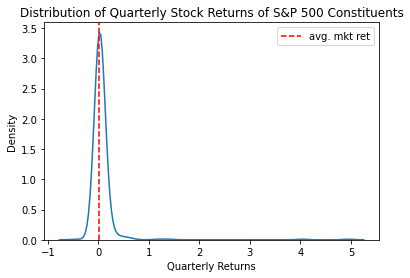

In [383]:
# distribution of quarterly asset returns to market return aggregated over entire in-sample period
sns.kdeplot(data=df_groupby_ticker, x='qtr_ret')
plt.axvline(df_groupby_ticker['SPX_qtr_rets'].mean(), color='red', linestyle='--', label='avg. mkt ret') 
plt.legend()
plt.title('Distribution of Quarterly Stock Returns of S&P 500 Constituents')
plt.xlabel('Quarterly Returns')
plt.savefig("/Users/taigaschwarz/Dev/quant-trading-mf703/output/distribution_rets.png", bbox_inches='tight',
            dpi=1200)
plt.show()

We see above that the distribution of the average asset returns is symmetric about the average market return. 

## Areas for Further Research (if given more time):  
* I would like to test this model on older data. Joseph Piotroski tested his F-score methodology on stock data from 1976 to 1996 and created a long-short investment strategy based on his fundamental metric to achieve a 23% annual return within the time period. As an important note, Piotroski focused his methodology on companies with high book-to-market ratios, in other words companies that are undervalued by the market. However, this period of time was before the true emergence of the internet and the high-growth tech companies (Amazon, Netflix, Facebook, to name a few) that grew with it, most of which currently hold lofty valuations. With exponential improvements in techology, one may hypothesize that active investors in this millenium place a larger emphasis on projected growth and future earnings compared to pre-internet times. Clearly, we observe today that tech companies are often priced many times higher than its earnings (Tesla is a good example), whereas this was likely not the case during the 1970s (would like to verify this). If this is indeed the case, then it would make sense that the fundamental metrics Piotroski used are not as effective in predicting future outperformance.  <br>


* I would like to do more data visualization before constructing the regression model. The parameters I choose are based off of my own theories on how to select stocks likely to outperform the market. However, we find that these predictors are not very significant. I would like to start with analyzing the relationship between outperformance and many different types of factors (technical and fundamental) to get an improved sense of what the potentially signficant relationships are before constructing the model.

# Back-Test

In [320]:
# functions
def back_test_data(X, mod, colname, intercept=None):
    '''inputs: X = predictors in back-test sample; mod = model; colname = name of the predicted values column;
               intercept = 'y' for include, 'n' for no '''
    if intercept == 'y':
        X['intercept'] = 1  # add an intercept column
    
    pred_results = mod.predict(X)
    X.loc[:,colname] = pred_results
    return X

In [388]:
# out-of-sample data
X_backtest = X2.loc['2017_1':'2020_4',:]
X_backtest = X_backtest[['CFO', 'CFO_size', 'ACCRUAL', 'dMARGIN']]
X_backtest = back_test_data(X_backtest, lrg_3, 'pred_beats_mkt', 'y')

# stocks predicted to beat
stocks_predicted_to_beat = X_backtest[X_backtest.loc[:,'pred_beats_mkt'] >= 0.5]
# order from highest predicted probability to outperform to lowest
stocks_predicted_to_beat = stocks_predicted_to_beat.reset_index().sort_values(['qtr','pred_beats_mkt'], 
                                                                              ascending=[True,False])
stocks_predicted_to_beat = stocks_predicted_to_beat.set_index(['qtr','ticker'])
stocks_predicted_to_beat.to_csv("/Users/taigaschwarz/Dev/quant-trading-mf703/output/backtest_stocks.csv")

# list of stocks predicted to beat and the number of times they are predicted to beat
list_of_stocks = stocks_predicted_to_beat.reset_index()['ticker'].value_counts()
list_of_stocks.columns = 'Count of Outperformance of Stocks Predicted to Beat'
list_of_stocks.to_csv("/Users/taigaschwarz/Dev/quant-trading-mf703/output/list_of_stocks.csv")

# top 5 stocks with the highest predicted probability to beat per quarter
stocks_predicted_to_beat = stocks_predicted_to_beat.reset_index().set_index('qtr')
highest_pred_prob_stocks = stocks_predicted_to_beat.groupby(by='qtr').head(5)
highest_pred_prob_stocks1 = stocks_predicted_to_beat.groupby(by='qtr').first()
highest_pred_prob_stocks.to_csv("/Users/taigaschwarz/Dev/quant-trading-mf703/output/highest_pred_prob_stocks.csv")
highest_pred_prob_stocks1.to_csv("/Users/taigaschwarz/Dev/quant-trading-mf703/output/highest_pred_prob_stocks1.csv")
print(highest_pred_prob_stocks['ticker'].value_counts())

CHTR     12
FANG      8
RCL       7
CCL       5
NCLH      5
WHR       3
CZR       3
WMB       3
XRAY      2
KMI       2
SBAC      2
MO        2
LYV       1
DLTR      1
WYNN      1
LVS       1
MPC       1
APA       1
CVX       1
OXY       1
HOLX      1
NWL       1
BRK-B     1
SBUX      1
KHC       1
AEP       1
MRO       1
QCOM      1
EIX       1
PENN      1
CERN      1
PEG       1
EXPE      1
Name: ticker, dtype: int64


There is a clear commonalities between the companies listed above. The top stocks predicted to have the highest probability of market outperformance are generally cruise line holdings companies, and then followed by petroleum and energy companies. The majority of the companies also have very simple business models compared to the likes of the large-cap Tech sector. I believe that this helps support my theory that the fundamental metrics that Piotroski used to model market outperformance in the 1970s - 1990s are no longer effective as standalone factors in today's world of finance. The model limits itself by focusing on value and by the data available in financial statements. It fails to capture the potential for future growth and earnings, which is the main driver in stock returns in high-growth companies. 

In [415]:
# daily market cap data
backtest_tickers = list(set(highest_pred_prob_stocks1['ticker']))
backtest_tickers

daily_hist_mkt_caps = []
for i in range(len(backtest_tickers)):
    mkt_cap_i = daily_hist_mkt_cap(backtest_tickers[i])
    daily_hist_mkt_caps.append(mkt_cap_i)

daily_mkt_cap_df = pd.concat(daily_hist_mkt_caps, axis=1)
daily_mkt_cap_df = daily_mkt_cap_df.loc['2020-12-31':'2017-01-01',:]  # slice into backtest sample
daily_mkt_cap_df = daily_mkt_cap_df.iloc[::-1]
daily_mkt_cap_df.columns = backtest_tickers
daily_mkt_cap_df.to_csv("/Users/taigaschwarz/Dev/quant-trading-mf703/output/daily_mkt_cap_data.csv")
daily_mkt_cap_df

,PENN,KHC,FANG,CHTR,NCLH,CCL,RCL
date,,,,,,,
2017-01-03,1.291560e+09,1.073118e+11,8.301300e+09,7.801521e+10,9.843417e+09,3.790578e+10,1.693335e+10
2017-01-04,1.342856e+09,1.066988e+11,8.327028e+09,7.959315e+10,1.029890e+10,3.840014e+10,1.706055e+10
2017-01-05,1.317208e+09,1.060858e+11,8.335068e+09,8.085441e+10,1.024829e+10,3.904717e+10,1.716150e+10
2017-01-06,1.258584e+09,1.058161e+11,8.334264e+09,8.139768e+10,1.017928e+10,3.900355e+10,1.702623e+10
2017-01-09,1.214616e+09,1.055218e+11,8.154972e+09,8.087898e+10,1.021148e+10,3.903263e+10,1.707064e+10
...,...,...,...,...,...,...,...
2020-12-24,1.471963e+10,4.274556e+10,7.615249e+09,1.384583e+11,6.671881e+09,1.615100e+10,1.479514e+10
2020-12-28,1.379363e+10,4.302662e+10,7.517586e+09,1.360660e+11,6.929744e+09,1.682525e+10,1.561034e+10
2020-12-29,1.372598e+10,4.264780e+10,7.418151e+09,1.387960e+11,6.891744e+09,1.660825e+10,1.533407e+10
